In [1]:
# Core functionality for managing and accessing data
from neurosynth import Dataset, decode, network
import nibabel as nib
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.io
import h5py
import glob

## Inputs

In [2]:

#choose the parc
parc = 'Sch214'
# and number of nodes to extract
n_nodes = 5
# and the mode
mode = 0

## Find rois from CCA analysis

In [3]:
# get rois of interest
docs_path = '/Users/luke/Documents/Projects/StrokeNet/Docs/'
conbound = 'conbound20/'
results_dir = docs_path + 'Results/' + conbound + parc + '/'
data = scipy.io.loadmat(results_dir + 'results.mat')
nodes = data['CCA'][0][0][14]
roi_list = np.ravel(np.vstack((nodes[0:n_nodes,0,mode],nodes[0:n_nodes,1,mode])))
print('rois include: '+str(roi_list))

rois include: [ 23 203  64  27  42 141 169 168 130 120]


## Load the parcellation

In [4]:
# get parcellation
#load the roi-parcellation
if parc=='Sch214':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/Schaefer200/Schaefer200_plus_HO.nii'
elif parc=='BN':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/BNAtlas/BN_Atlas_246_2mm.nii'
img_parc = nib.load(parcellation_file)
img_parc_data = img_parc.get_data()

## Load the neurosynth dataset and features

Features are from Poldrack et al., 2012 (https://github.com/poldrack/LatentStructure). There are ~500 unique features.

In [5]:
path_to_neurosynthdata = '/Users/luke/Documents/Projects/StrokeNet/Data/topicMapping/'

# load the pickle
dataset = Dataset.load(path_to_neurosynthdata+'dataset.pkl')

# get features - https://github.com/poldrack/LatentStructure
features_df = pd.read_csv(path_to_neurosynthdata+'Poldrack_2012_terms.csv',header=None)
features_df.replace('_', ' ', regex=True,inplace=True)
cognitive_features = features_df[0].tolist()
cognitive_features = np.unique(cognitive_features)
print('number of unique terms:'+ str(np.shape(cognitive_features)))

number of unique terms:(545,)


## Save rois as Nifti

In [6]:
for roi in roi_list:
    roi_img = np.zeros((np.shape(img_parc_data)))
    roi_img[img_parc_data==roi]=1
    roi_img = nib.Nifti1Image(roi_img,img_parc.affine)
    out_name = path_to_neurosynthdata+'roi/'+parc+'_roi_'+str(roi)+'.nii'
    nib.save(roi_img,out_name)

## Decode the rois

### Association based decoding
Not appropriate for binary rois

In [7]:
## association method
# set up the decoder
#decoder = decode.Decoder(dataset,features=cognitive_features)

#nii_list=[]
#for nii in range(n_nodes*2):
#    roi = roi_list[nii]
#    nii = parc+'_roi_'+str(roi)
#    nii_list.append('roi/'+nii+'.nii')
    
#run the decoding
#neurosynth_results = decoder.decode(nii_list, save='decoding_results_Schaefer.txt')
#neurosynth_results.head()

### Roi based decoding
from: https://groups.google.com/forum/#!searchin/neurosynthlist/method$3D$27roi$27|sort:date/neurosynthlist/7kyLBuTXUGQ/_Xrt3pF3BQAJ

*You can select that one by passing method='roi', but be aware that it won't produce meaningful results unless you have a binary mask. Basically, it does a meta-analytic comparison of all studies that activate within the passed ROI versus all the ones that don't. If your input _is_ binary, I would probably recommend using this approach rather than the pearson approach. Otherwise stick with pearson (unless you want to implement new methods, which I would certainly welcome).*

In [8]:
## roi method
# set up the decoder
decoder = decode.Decoder(dataset,method='roi')

nii_list=[]
for nii in range(n_nodes*2):
    roi = roi_list[nii]
    nii = parc+'_roi_'+str(roi)
    nii_list.append(path_to_neurosynthdata+'roi/'+nii+'.nii')
    
#run the decoding
neurosynth_results = decoder.decode(nii_list, save=path_to_neurosynthdata+'decoding_results_'+parc+'_mode'+str(mode)+'.txt')
neurosynth_results.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
001,-1.1034,1.0838,-2.8988,-1.8067,-0.4045,-1.5783,-2.1258,-1.1449,0.6633,-1.2152
01,-0.2889,-0.2818,-2.7764,-0.2125,-2.1161,-1.2996,-2.2467,-1.8472,0.7771,-0.8006
05,-0.3670,-0.5181,-3.4135,-0.3538,-1.2021,-1.6595,-3.0357,-3.1473,-0.6908,-0.4724
10,-0.9470,-0.4484,-1.2901,-1.1231,1.4787,-1.5740,-0.8358,-0.8572,0.4094,-1.0435
100,2.7565,-1.2760,-1.5542,-0.2627,-0.1342,-0.2329,-0.6951,-1.0905,-0.8128,0.5031


#### trim the results to useful features

In [9]:

idx = neurosynth_results.index.isin(cognitive_features)

neurosynth_results_trimmed = neurosynth_results[idx]
neurosynth_results.to_csv(path_to_neurosynthdata+'decoding_results_'+parc+'_mode'+str(mode)+'_trimmed.txt')
neurosynth_results_trimmed.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
action,-1.8829,0.0342,8.1026,4.5956,0.9354,7.1424,0.1543,4.8810,1.9360,6.5935
adaptation,-0.9151,-1.4924,-0.8036,-1.9116,-1.3564,-1.2590,-0.8714,0.3122,-1.8216,-1.3186
anticipation,2.4234,6.3779,-1.6305,-0.8782,1.5285,-0.5475,-1.8932,-0.1213,-0.5582,2.1773
arousal,1.2123,1.3010,-1.3957,-1.4511,3.3515,-0.0154,0.1134,-1.2607,-0.8910,0.1081
association,-0.2698,0.5569,-0.2516,-0.4670,-0.7868,-1.5531,-1.3624,-2.4692,-0.0973,-0.7222


## Visualise the results

In [10]:
def word_brain_plot(df,nii):
    #https://github.com/amueller/word_cloud
    import matplotlib.pyplot as plt
    from nilearn import plotting
    from wordcloud import WordCloud

    def getWordFreq(df,nii):
        text = df.index.values
        freq = df[nii].values*10000
        tmpDict={}
        for i,word in enumerate(text):
            val = freq[i]
            tmpDict[word.lower()] = np.round(val)
        return tmpDict

    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(getWordFreq(df,nii))

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fname, dpi=600)
    plt.show()
    
    # brain
    plotting.plot_stat_map(nii,threshold=0.1, title=nii)
    plotting.show()

def word_brain_plot_roi(df,nii,col,fname):
    #https://github.com/amueller/word_cloud
    import matplotlib.pyplot as plt
    from nilearn import plotting
    from wordcloud import WordCloud

    def getWordFreq(df,col):
        text = df.index.values
        freq = df[col].values*10000
        tmpDict={}
        for i,word in enumerate(text):
            val = freq[i]
            tmpDict[word.lower()] = np.round(val)
        return tmpDict

    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(getWordFreq(df,col))

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fname, dpi=600)
    plt.show()

    # brain
    plotting.plot_roi(nii,threshold=0.1, title=nii)
    plotting.show()

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/lib/python3.7/site-packages/wordcloud/wordcloud.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='/anaconda3/lib/python3.7/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


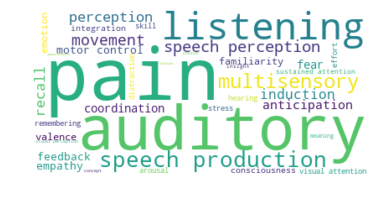

/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


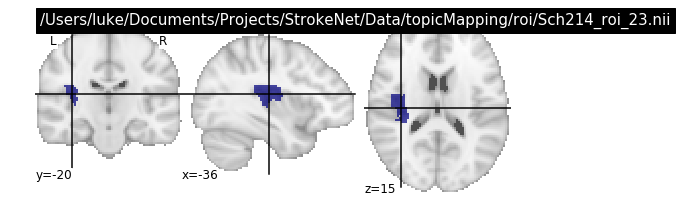

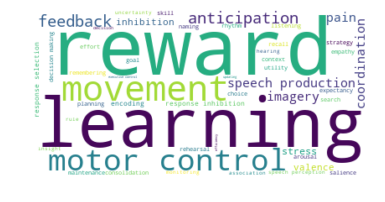

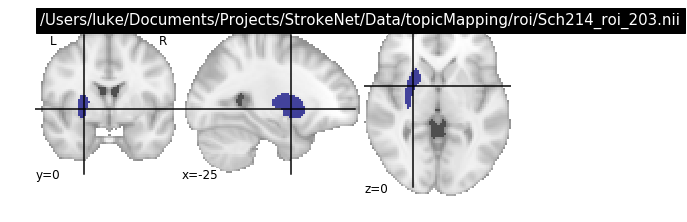

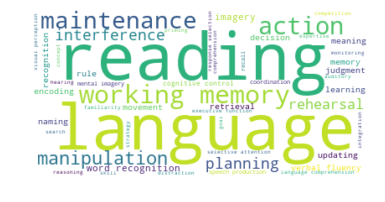

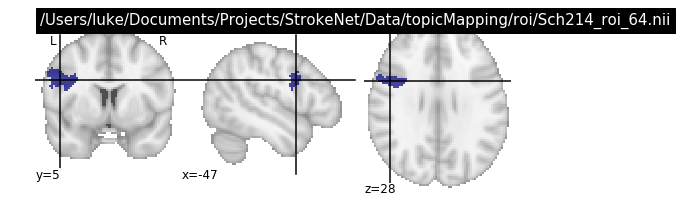

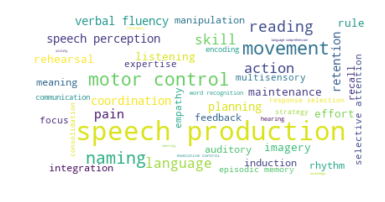

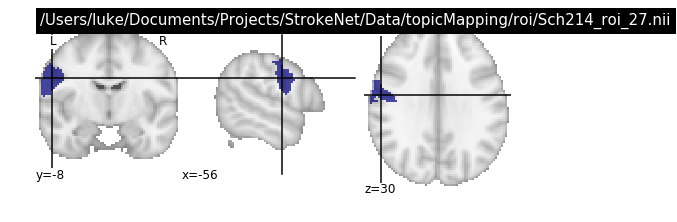

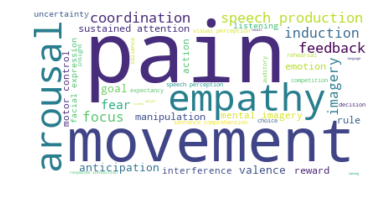

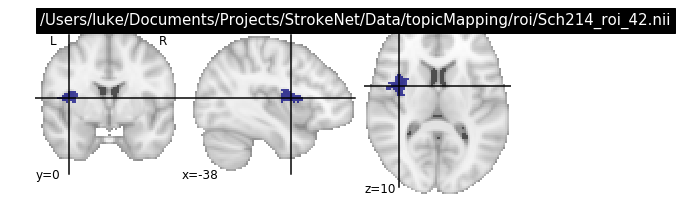

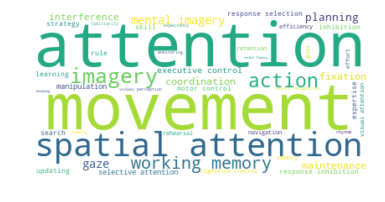

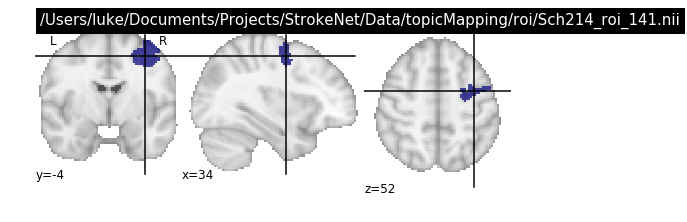

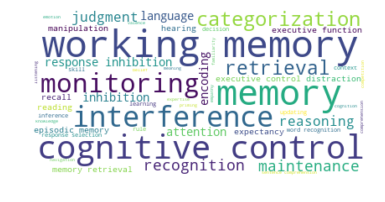

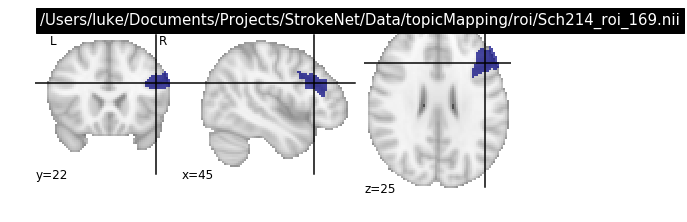

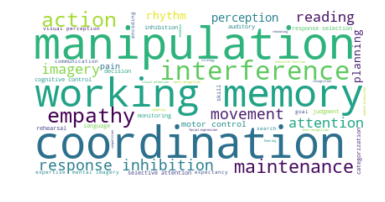

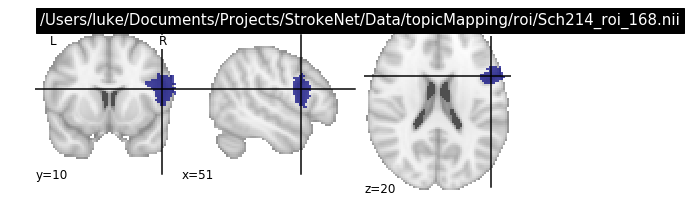

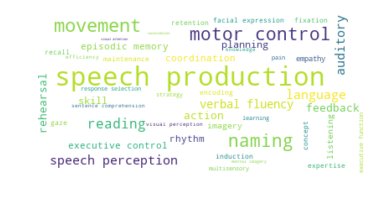

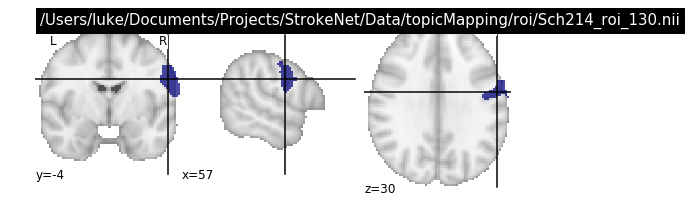

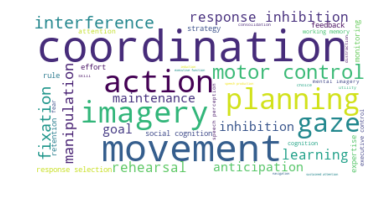

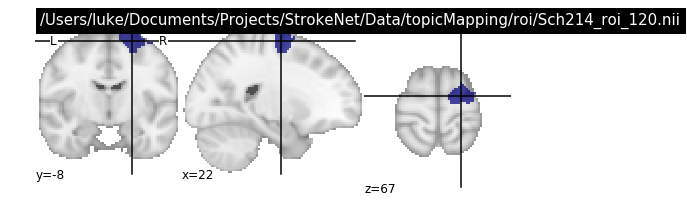

In [11]:

for i,roi in enumerate(roi_list):
    nii = nii_list[i]
    fname = path_to_neurosynthdata+'word_clouds/decoding_results_roi'+str(i)+'_'+parc+'_mode'+str(mode)+'_trimmed.jpeg'
    word_brain_plot_roi(neurosynth_results_trimmed,nii,'cluster_'+str(i),fname)

## Calculate meta-coactivation

*from: https://groups.google.com/forum/#!msg/neurosynthlist/ch-Ps5fwo00/cWWDUC4yRtoJ*

p: probability
A: activation
g: given
F: feature present
z: z-score
FDR: FDR-corrected (the value after that is the specific false positive rate used in the correction, e.g., 0.05)

Which gives us:

_pA: the probability of a study reporting activation at that voxel (i.e., the proportion of all studies in the Neurosynth database that report activation). This is just a base rate map so you can get a sense of how activation is distributed around the brain (without any consideration for the particular terms you're using in the meta-analysis).

_pAgF: the probability of activation given that a study is tagged with the feature (in your case, whatever Social Perception is). This is what I refer to as forward inference on the website and in the paper.

_pAgF_given_pF=0.5: same as above, but with a uniform prior imposed (i.e., we pretend there is an equal probability of a study being in the SocialPerception set or not being in the SocialPerception set). This is important as it allows you to compare different features (otherwise the results are dominated by the empirical prior).

_pAgF_z: z-score map corresponding to the _pAgF map. I.e., where the _pAgF map gives you the point estimate of effect size, the _z map gives you the a sense of the confidence in the inference that a voxel is or is not consistently activated for (in this case) SocialPerception studies.

_pAgF_z_FDR* : self-explanatory.

_pFgA, _pFgA_given_pF=0.5, etc.: These are all the same as the pAgF maps, except they're what we refer to as reverse inference rather than forward inference. In other words, they're telling you about the probability that a study in the database is tagged with a particular feature given that activation is present at a particular voxel. So whereas the pAgF maps are maps of consistency (roughly, if someone reports a SocialPerception study, where is activation likely to be reported), the pFgA are maps of specificity (i.e., if you see activation at a particular voxel, how much more likely is a study to be associated with SocialPerception than not).